# Causal Mediation Analysis I: Introduction

In this tutorial, we'll introduce **causal mediation analysis**, which aims to discover which intermediate computations play a **causal role** in a model's computation.

Before we begin, we encourage you to read through [causal models](https://) introductory tutorial, which gives a brief overview of causal models and operations we can perform on them.

This tutorial will introduce causal mediation analysis on a neural network in a toy arithmetic setting. Along the way, we'll cover:
* **Total, Direct, and Indirect Effects**: how can we understand the causal effects of intermediate variables?
* **Interchange interventions (aka patching)**: a key operation for causal mediation analysis.
* **Explaining a toy neural network**: what does it look like to interpret a neural network?

**Note**

For this tutorial, feel free to use a CPU machine. We will be analyzing a toy neural network that won't require lots of compute.

📗 Prefer to use Colab? Follow the tutorial [here](https://colab.research.google.com/drive/12_ItIeQFs2OKoYwJ9O8YVM4kjD25qv2K)!

## 0️⃣ Setup

In [2]:
# clone causal abstractions library for causal model
# clone nnsight-tutorials library for util functions
import sys
from IPython.display import clear_output

!git clone https://github.com/atticusg/CausalAbstraction.git
!git clone https://github.com/AmirZur/nnsight-tutorials.git

sys.path.append('CausalAbstraction')
sys.path.append('nnsight-tutorials')

clear_output()

In [3]:
import plotly.io as pio

try:
    import google.colab
    is_colab = True
except ImportError:
    is_colab = False

if is_colab:
    pio.renderers.default = "colab"

    # install dash cytoscape for graph visualizations
    !pip install dash dash-cytoscape

    # install nnsight to analyze neural network internals
    !pip install -U nnsight
else:
    pio.renderers.default = "plotly_mimetype+notebook_connected+notebook"

clear_output()

## 1️⃣ Causal mediation

When interpreting a neural network model, we want to understand which components of the model are responsible for different questions. Another way to ask this is, what **causal effect** does a neuron (or other model component) have on the model's computation?

Imagine we have a neural network that computes the function `Y = A + B + C`. How does the model add the three numbers together? Does it add them together all at once, or does it form any intermediate computations? Soon we'll see how **causal mediation analysis** can help us answer these questions!

![2-layer neural network with 3 neurons in each layer; the input is 1 + 2 + 3 and the output is 6](https://github.com/AmirZur/nnsight-tutorials/blob/main/figures/neural_network.png?raw=true)

In [6]:
# load a toy neural network that computes A + B + C
from causal_mediation_utils import get_toy_model

toy_model = get_toy_model()
toy_model

ToyModel(
  (l1): Linear(in_features=3, out_features=3, bias=True)
  (l2): Linear(in_features=3, out_features=3, bias=True)
  (l3): Linear(in_features=3, out_features=1, bias=True)
)

First things first, let's do some behavioral evaluation to make sure that our model is really up to the task! Play around a bit to test whether the model correctly sums up its inputs.

In [ ]:
inputs = [1, 2, 3] # must be 3 numbers
output = toy_model(inputs).item()
print(round(output, 2)) # round to 2 decimal places

6.0


### Neural networks are causal models too!

One great thing about causal analysis is that causal models are all around us! We can frame physical systems, social dynamics, or complex computations as a causal graph consisting of many intermediate computations. In fact, neural networks suit this paradigm quite well! We can think of each individual **neuron** in a network's **activations** as a **causal variable**, and the network's **parameters** as the **edges** linking neurons together.

Let's visualize our toy neural network as a causal graph!

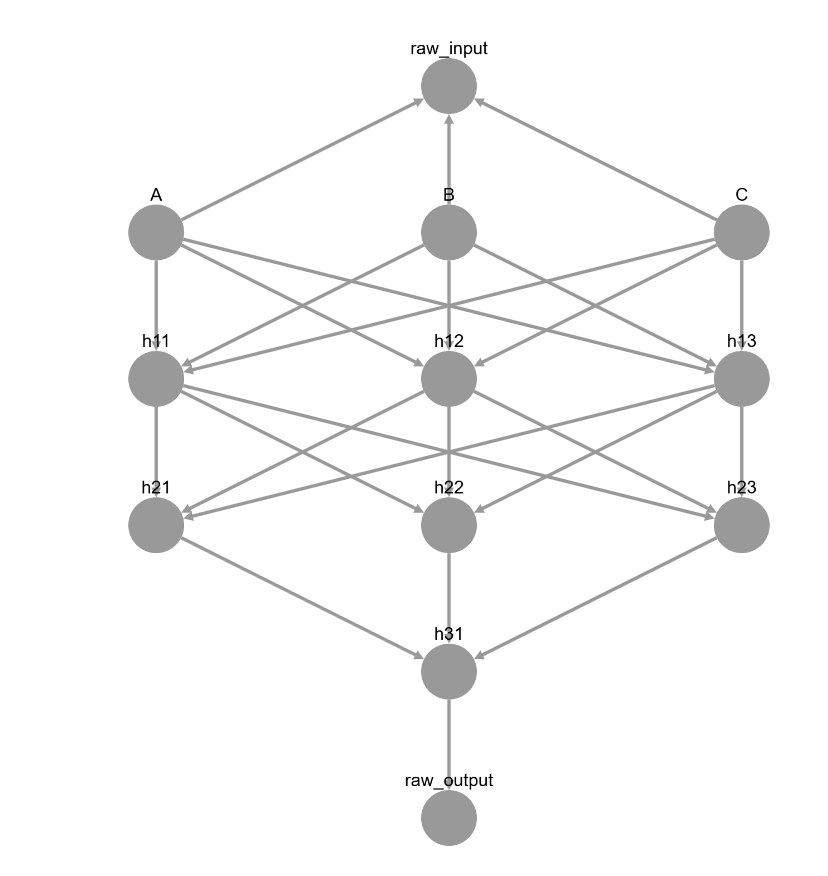

In [ ]:
from causal_mediation_utils import get_causal_graph_of_toy_model

toy_model_graph = get_causal_graph_of_toy_model(toy_model)

toy_model_graph.display_structure()

Can we make sense of the model's intermediate computations right away like this? Let's give it a try: with `nnsight`, we'll store the neurons at each layer and print out their values.

In [7]:
# use nnsight to inspect the internals of our model!
import nnsight

toy_model = nnsight.NNsight(toy_model)

In [ ]:
# save intermediate values of the neural network
import torch

inputs = [1, 2, 3]
with torch.no_grad():
    with toy_model.trace(inputs): # trace the forward pass of the network
        h1 = toy_model.l1.output.save()
        h2 = toy_model.l2.output.save()
        h3 = toy_model.l3.output.save()

print('Neurons in layer 1:', h1.tolist())
print('Neurons in layer 2:', h2.tolist())
print('Neurons in layer 3:', h3.tolist())

Neurons in layer 1: [10.889999389648438, 8.100000381469727, 12.300000190734863]
Neurons in layer 2: [6.013899803161621, 3.705000638961792, -0.2709999978542328]
Neurons in layer 3: [6.000000953674316]


We can visualize the same values we just got for the neurons as a forward pass of a causal graph.

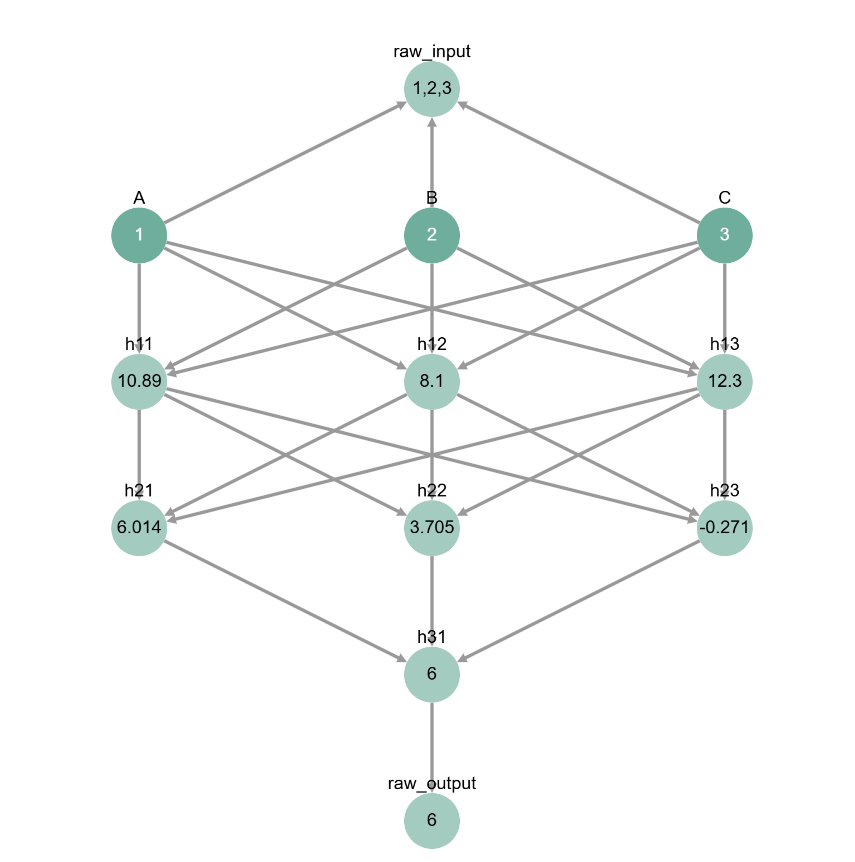

In [ ]:
# display neural activations as causal graph
inputs = {'A': inputs[0], 'B': inputs[1], 'C': inputs[2]} # get inputs from cell above
toy_model_graph.display_forward_pass(inputs)

Even with the visualization, it's hard to tell what the intermediate values of our network actually mean...

Perhaps, we shouldn't focus on understanding what the values of these neurons is, and instead try to understand their **function** within the network as whole. To do this, we can measure the **causal effect** of each neuron.

### Causal mediators

Visualizing our neural network as a causal graph doesn't immediately help us make meaning of its neurons, but it does help convey a key point: the model starts with `A = 1, B = 2, C = 3` and ends with `Y = 6`; this means that **somewhere**, **somehow**, the model is adding together its inputs -- and this information **must be represented** in the intermediate neurons.

We call neurons that hold information relevant to the output **causal mediators**, since they **mediate** the effect of the input (1 + 2 + 3) on the output (6).

![three nodes, where the input x directly connects to the output y, but x also connects to y by taking a path through a third node labeled m](https://github.com/AmirZur/nnsight-tutorials/blob/main/figures/causal_mediator.png?raw=true)

Even though every neuron stands between the input and the output in our visualization, **not every neuron is a mediator**! Some neurons might not even get activated by our input (i.e., their values won't change across different inputs). For example, look at how the value of the last neuron in the second layer (`h23`) doesn't change no matter what the input is!

_(note: we purposefully set up the neural network to have this behavior, but this could also happen in practice with large AI models!)_

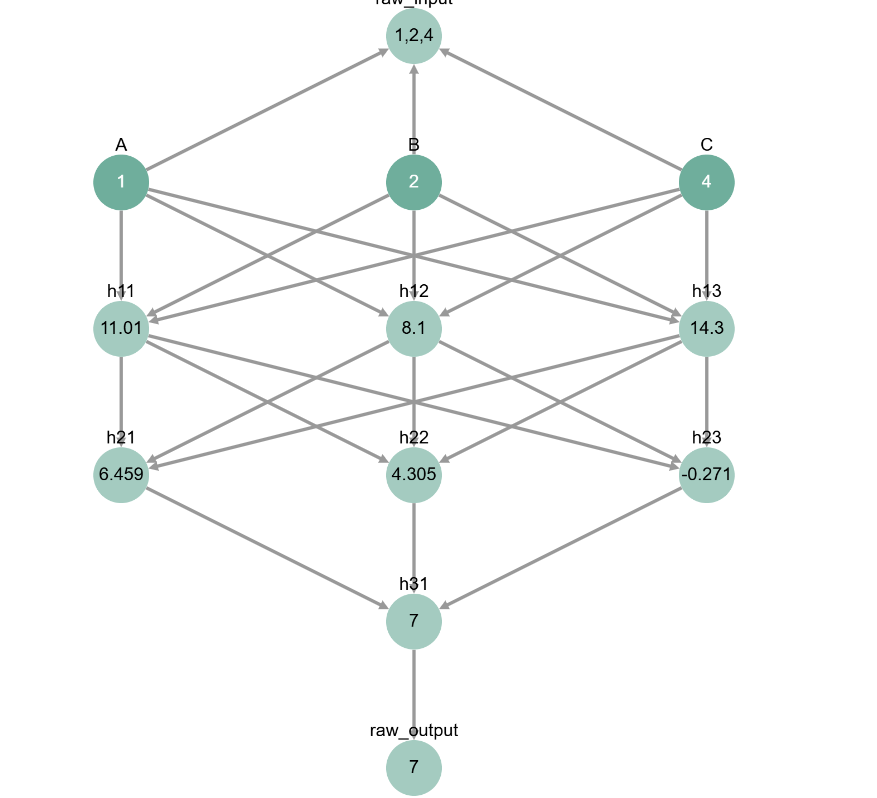

In [ ]:
# change the inputs and focus on the value of h23
inputs = [1, 2, 4]
inputs = {'A': inputs[0], 'B': inputs[1], 'C': inputs[2]}
toy_model_graph.display_forward_pass(inputs)

A **causal mediator** has to have a **causal effect** on the final output. Notice how changing the value of `h23` directly with `nnsight` doesn't affect the model's final output.

In [ ]:
# intervene on h23
inputs = [1, 2, 3]
new_h23_value = -100 # change h22 to any value you want!

with torch.no_grad():
    with toy_model.trace(inputs):
        # change value of last neuron in second layer
        toy_model.l2.output[-1] = new_h23_value
        output = toy_model.output.item().save()

print(output)

6.000000953674316


Here we're visualizing the same intervention as the code in the cell above.

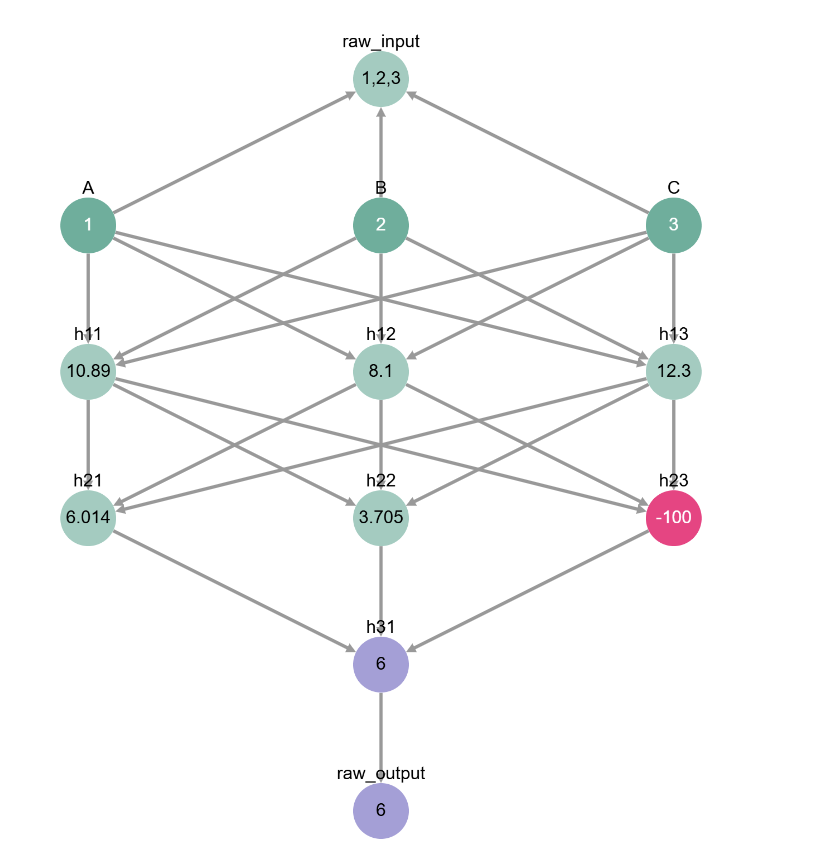

In [ ]:
# visualize the cell above
inputs = {'A': inputs[0], 'B': inputs[1], 'C': inputs[2]}
intervention = {'h23': new_h23_value}
toy_model_graph.display_forward_pass(inputs, intervention)

So how do we find the neurons that mediate the model's computation? This is where causal mediation analysis comes in!

## 2️⃣ Total, Direct, and Indirect Effect

In the section above we saw how to determine when a neuron _doesn't_ have causal effect - we could change its value to whatever we wanted, and it didn't seem to affect the output at all - but the space of interventions we'd need to search over is huge. It's probably not a great idea going about plugging in random values into our intermediate neurons.

Instead, we can use the fact that **neurons take on different values** when processing different inputs. By **interchanging** (or **patching**) these values, we can measure the causal effect of a neuron.

![visualization of total, direct, and indirect effects](https://github.com/AmirZur/nnsight-tutorials/blob/main/figures/causal_effects.png?raw=true)

Let's focus on finding the neurons that mediate the input `A` in `A + B + C`. To do this, we want to set up a pair of inputs, a **base** and a **source**, that **only** differ with respect to `A`.

_(note: sometimes literature refers to these inputs as "clean" and "corrupted")_

In [ ]:
# set up base input & source input where only A is different
base_inputs = [1, 2, 3]
source_inputs = [4, 2, 3]

### Total effect

The **total effect** of input `A` is how much the model's output changes when we change input `A` and nothing else. We don't need to change any model internals for this. Simply running the model forward on the base and source input is enough.

In [ ]:
# compute total effect
base_output = round(toy_model(base_inputs).item(), 2)
source_output = round(toy_model(source_inputs).item(), 2)
print('Base output:', base_output)
print('Source output:', source_output)

Base output: 6.0
Source output: 9.0


This is what measuring the **total effect** of `A` looks like on our causal graphs. What we're doing is **swapping the value of A** between the base and the source.

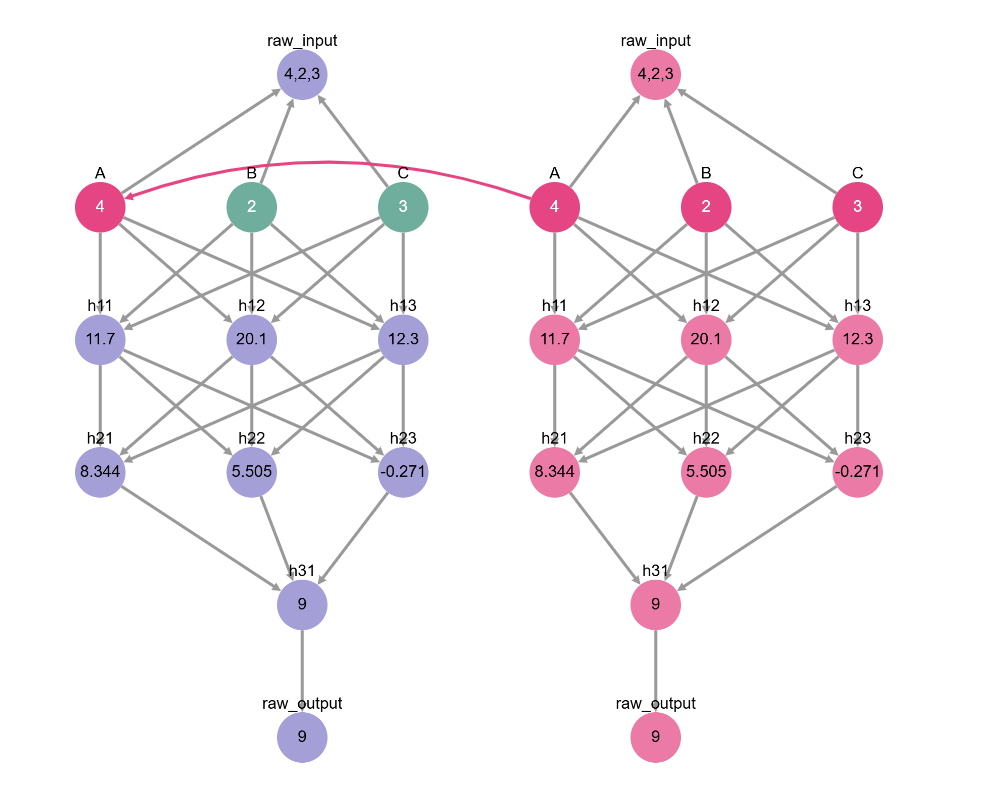

In [ ]:
# visualize the cell above
base_causal_input = {'A': base_inputs[0], 'B': base_inputs[1], 'C': base_inputs[2]}
source_causal_input = {'A': source_inputs[0], 'B': source_inputs[1], 'C': source_inputs[2]}
toy_model_graph.display_interchange(base_causal_input, {'A': source_causal_input})

We say that `A` has a **causal effect** if changing `A` alone changes the output. Indeed, it seems that it does! So it's not so surprising that `A` has a causal effect on our model.

The **total effect** only looks at the input, since it's not changing any internals in the neural network. To understand the causal effect of an intermediate variable, we must break it down into its **direct effect** and its **indirect effect** (how much it **restores** and how much it **disrupts**).

### Direct effect

The **direct effect** of a variable is how much it **restores** the computation of the model when it's thrown into the computation of a different input.

Imagine that we started computing `4 + 2 + 3`, but in the middle of the operation we swapped out the value of the middle neuron in the first layer (`h12`). Is that enough to restore the base computation `1 + 2 + 3`? The extent to which we can **restore** the base output (`6`) by intervening on `h12` corresponds to its **direct effect**.  

Let's try to see if neuron `h12` has a direct causal effect using `nnsight`! Here's the gameplan:
1. Run a forward pass on the **base input** and store the value of `h12`.
2. Run a forward pass on the **source input** and **intervene** on `h12` by patching in its base value from (1).
3. Collect the result of the **intervened run** and check - did `h12` restore the value of the base output (`6`)?

In [ ]:
# find the direct effect of h12

# forward pass on base input
with toy_model.trace(base_inputs):
    # 1. collect base value of h12
    base_h12_value = toy_model.l1.output[1].save()
    # save base value
    base_output = toy_model.output.save()

# forward pass on source input
with toy_model.trace(source_inputs):
    # 2. set source value of h12 to base value
    toy_model.l1.output[1] = base_h12_value
    # 3. save final output & compare to base value
    intervened_output = toy_model.output.save()

# compare: if we successfully restored the base value, then h12 has a causal effect!
base_output = round(base_output.item(), 2)
intervened_output = round(intervened_output.item(), 2)
print('Base output:', base_output)
print('Intervened output:', intervened_output)

Base output: 6.0
Intervened output: 6.0


Behold! Swapping the value of the middle neuron in the first layer (`h12`) restored the original base computation. We can then say that `h12` has a **direct effect** on the output when mediating `A`.

Unfortunately we don't have a great visualization of this code using the causal models library without using confusing colors. So instead, we'll provide a visualization of **indirect effect** in the next section. In our case, they end up being very similar!

### Indirect effect

We saw that `h12` has a **direct effect** in mediating `A`. Does it also have an **indirect effect**?

The **indirect effect** of a neuron is how much of the base computation it **disrupts** when it gets swapped out with a different source value. For example, if we try to compute `1 + 2 + 3` and swap `h12` out with a different value, will we still get the output `6`?

Let's try implementing this in `nnsight`. It will look very similar to how we compute direct effect, but with the **base** and **source** inputs swapped.
1. Run a forward pass on the **source input** and store the value of `h12`.
2. Run a forward pass on the **base input** and **intervene** on `h12` by patching in its source value from (1).
3. Collect the result of the **intervened run** and check - did `h12` change the value of the base output?

In [ ]:
# find the indirect effect of h12

# forward pass on source input
with toy_model.trace(source_inputs):
    # 1. collect source value of h12
    source_h12_value = toy_model.l1.output[1].save()

# forward pass on base input
with toy_model.trace(base_inputs):
    # 2. set base value of h12 to source value
    toy_model.l1.output[1] = source_h12_value
    # 3. save final output & compare to base value
    intervened_output = toy_model.output.save()

# compare: if the base value changed, it had to be because of h12...
intervened_output = round(intervened_output.item(), 2)
print('Base output:', base_output)
print('Intervened output:', intervened_output)

Base output: 6.0
Intervened output: 9.0


Behold once more! The neuron `h12` also has an **indirect effect** when mediating `A`! It's almost like we chose to start with this neuron on purpose...

This time, let's visualize how we computed the indirect effect using causal graphs. We swap the value of `h12` between the source run (on the right) and the base run (on the left). Note how swapping just `h12` makes the base output be the same as the source output!

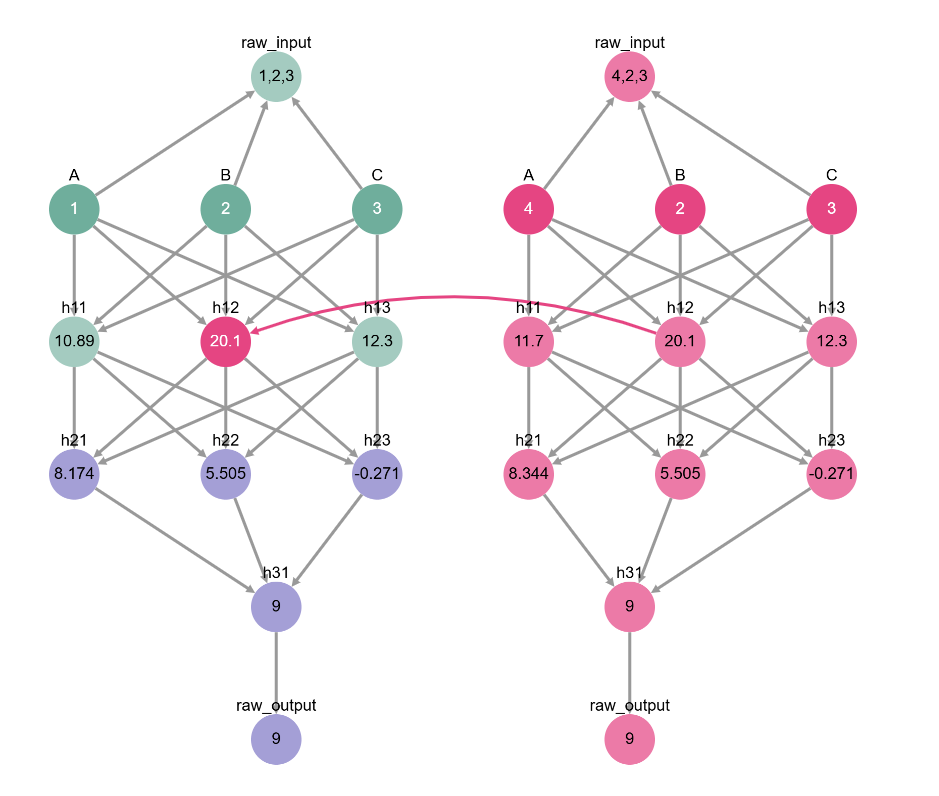

In [ ]:
# visualize indirect effect of h12
base_input = {'A': base_inputs[0], 'B': base_inputs[1], 'C': base_inputs[2]}
source_input = {'A': source_inputs[0], 'B': source_inputs[1], 'C': source_inputs[2]}
toy_model_graph.display_interchange(base_input, {'h12': source_input})

From now on, unless stated otherwise we'll focus on **indirect effect** in our experiments. It's easier to find neurons that change the base behavior than to find neurons that restore its behavior in a completely different input setting. However, oftentimes we'll be measuring both - if the intervention on our neuron restores the source output (just like how intervening on `h12` restored `9`), then that neuron has both a direct & an indirect effect.

### Causal effect depends on what we're trying to mediate

Wow, so `h12` has a **direct effect** *and* a **indirect effect** when we change the value of `A`. Does this mean it will always have a causal effect on our output?

Turns out, not really! Although we usually use "causal effect" to mean "influence the output", causal mediation analysis measures **causal effect in relation to the variable we're mediating**! To see what we mean, look at what happens to the causal effect of `h12` when we try to mediate `B` instead of `A`.

In [ ]:
# change the base & source to be different with respect to B instead of A
base_inputs = [1, 2, 3]
source_inputs = [1, 4, 3]

# forward pass on source input
with toy_model.trace(source_inputs):
    # 1. collect source value of h12
    source_h12_value = toy_model.l1.output[1].save()

# forward pass on base input
with toy_model.trace(base_inputs):
    # 2. set base value of h12 to source value
    toy_model.l1.output[1] = source_h12_value
    # 3. save final output & compare to base value
    intervened_output = toy_model.output.save()

# did the base output change this time? if not, then h12 might not have a causal effect...
intervened_output = round(intervened_output.item(), 2)
print('Base output:', base_output)
print('Intervened output:', intervened_output)

Base output: 6.0
Intervened output: 6.0


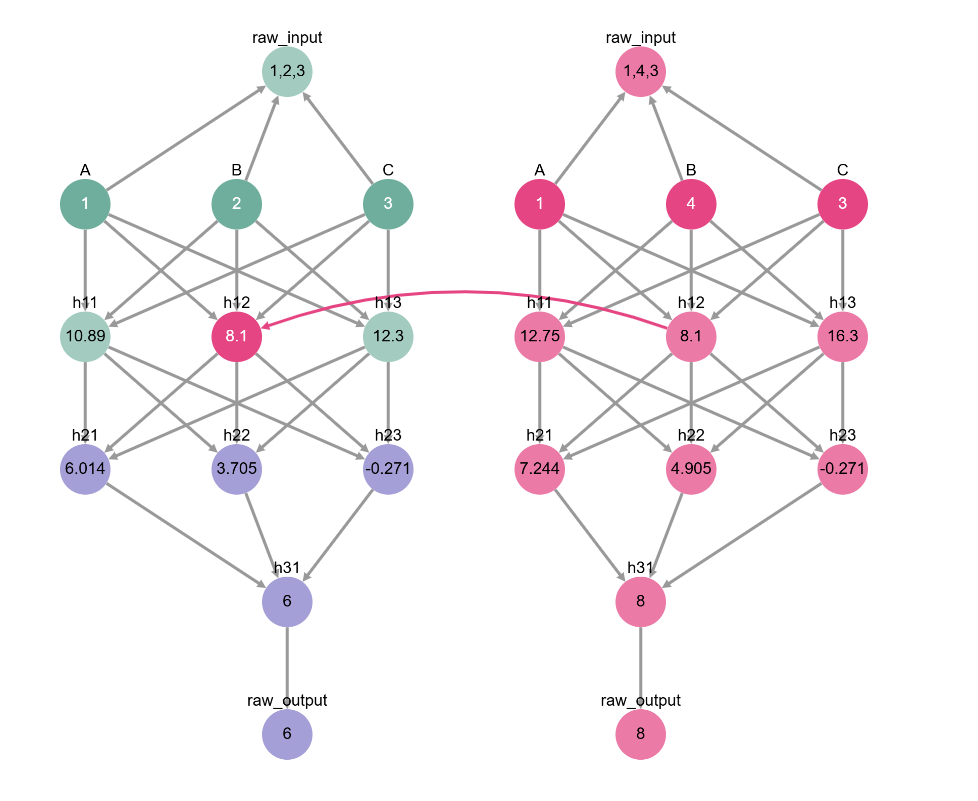

In [ ]:
# change B instead of A -> does h12 still make a difference?
base_input = {'A': base_inputs[0], 'B': base_inputs[1], 'C': base_inputs[2]}
source_input = {'A': source_inputs[0], 'B': source_inputs[1], 'C': source_inputs[2]}
toy_model_graph.display_interchange(base_input, {'h12': source_input})

Doing this experiment tells us something interesting: the neuron `h12` mediates the value of `A` but *not* of `B`. We're starting to piece things together about our model! Maybe it's adding together `A + C` first, and only then adding `B`? Or maybe it's writing down `A` to remember for later?

Let's put together what we learned to interpret our arithmetic model with causal mediation analysis!

## 3️⃣ Causal mediation analysis on a toy network

Now that we understand **causal mediation** and **causal effect**, we can put our learning to use in explaining our arithmetic model.

Last section, we stumbled upon how the middle neuron in the first layer (`h12`) mediates the variable `A`. This time, let's be more rigorous and search over all neurons in the network. With a small enough network, we can go one neuron at a time.

_(note: in larger networks like LLMs, we might need to consider larger units like residual streams or attention heads - which we'll cover in the [next tutorial](https://) - or consider using optimization instead of a grid search - see the [DAS tutorial](https://nnsight.net/notebooks/tutorials/causal_mediation_analysis/DAS/) for an example)_

Do other neurons also mediate the effect of `A` on the output? To find out, let's construct a dataset of paired inputs where only `A` changes.

In [8]:
# generate dataset where only A changes between base & source examples
import random

random.seed(42)
DIGITS = list(range(10))
N = 50 # size of dataset

dataset_mediating_A = []
for _ in range(N):
    # randomly select a base input
    base_input = [random.choice(DIGITS), random.choice(DIGITS), random.choice(DIGITS)]

    # change A (the first number) in the base input to get a source input
    source_input = base_input.copy()
    not_base_A = DIGITS[:base_input[0]] + DIGITS[base_input[0] + 1:] # don't repeat base input
    source_input[0] = random.choice(not_base_A)

    dataset_mediating_A.append({'base': base_input, 'source': source_input})

print(dataset_mediating_A[0])

{'base': [1, 0, 4], 'source': [4, 0, 4]}


We can use our dataset to measure the indirect effect of each neuron of our network in mediating `A`.

In [9]:
# compute the causal effect of each neuron in our model in mediating A
toy_model_components = [toy_model.l1, toy_model.l2, toy_model.l3]

def compute_causal_effect(dataset, layer : int, neuron : int):
    # keep track of number of times neuron had an effect
    num_examples_with_effect = 0
    for inputs in dataset:
        base_inputs, source_inputs = inputs['base'], inputs['source']

        with toy_model.trace(source_inputs):
            # 1. collect source value of h12
            source_h12_value = toy_model_components[layer].output[neuron].save()
            source_output = toy_model.output.item().save()

        # forward pass on base input
        with toy_model.trace(base_inputs):
            # 2. set base value of h12 to source value
            toy_model_components[layer].output[neuron] = source_h12_value
            # 3. save final output & compare to base value
            intervened_output = toy_model.output.item().save()

        # this is techincally direct effect:
        # we want the intervened output to match the source output
        # (for indirect effect, it's enough for the intervened output to be different from the base output)
        if intervened_output == source_output:
            num_examples_with_effect += 1

    # we return the "interchange intervention accuracy", or how many examples had an effect
    return num_examples_with_effect / len(dataset)

# let's go over each layer & neuron and compute its causal effect
causal_effects = []
for layer in range(2):
    causal_effects_per_layer = []
    for neuron in range(3):
        causal_effect = compute_causal_effect(dataset_mediating_A, layer, neuron)
        causal_effects_per_layer.append(causal_effect)
    causal_effects.append(causal_effects_per_layer)

In [10]:
# visualize our results!
import plotly.express as px

fig_a = px.imshow(
    causal_effects,
    x=["1", "2", "3"],
    y=["1", "2"],
    template='simple_white',
    color_continuous_scale=[[0, '#FFFFFF'], [1, "#A59FD9"]]
)

fig_a.update_layout(
    xaxis_title='neuron index',
    yaxis_title='layer index',
    yaxis=dict(autorange='min')
)

fig_a

The above plot looks a little funny, but it's picking out the neurons that mediate `A` when the model computes `A + B + C`. Looks like the middle neurons, `h12` and `h22`, mediate the effect of input `A`!

![the neural network with the two middle nodes h12 & h22 highlighted](https://github.com/AmirZur/nnsight-tutorials/blob/main/figures/neurons_mediating_A.png?raw=true)

Okay, how about variable `B`? Let's do the same thing again! We'll set up a dataset for `B` and test out the effect of each neuron at a time.

In [11]:
# 1. gather dataset of bases & sources where only B changes
dataset_mediating_B = []
for _ in range(N):
    base_input = [random.choice(DIGITS), random.choice(DIGITS), random.choice(DIGITS)]
    source_input = base_input.copy()
    # switch up B (index 1) btw the base & the source
    not_base_B = DIGITS[:base_input[1]] + DIGITS[base_input[1] + 1:]
    source_input[1] = random.choice(not_base_B)

    dataset_mediating_B.append({'base': base_input, 'source': source_input})

print('Example datapoint:')
print(dataset_mediating_B[0])

# 2. compute causal effects with dataset
causal_effects = []
for layer in range(2):
    causal_effects_per_layer = []
    for neuron in range(3):
        causal_effect = compute_causal_effect(dataset_mediating_B, layer, neuron)
        causal_effects_per_layer.append(causal_effect)
    causal_effects.append(causal_effects_per_layer)

# 3. plot results!
fig_b = px.imshow(
    causal_effects,
    x=["1", "2", "3"],
    y=["1", "2"],
    template='simple_white',
    color_continuous_scale=[[0, '#FFFFFF'], [1, "#A59FD9"]]
)

fig_b.update_layout(
    xaxis_title='neuron index',
    yaxis_title='layer index',
    yaxis=dict(autorange='min')
)

fig_b

Example datapoint:
{'base': [0, 5, 1], 'source': [0, 9, 1]}


The plot above corresponds to these neurons in our network:

![the neural network with nodes h13 (bottom right) and h22 (top middle) highlighted](https://github.com/AmirZur/nnsight-tutorials/blob/main/figures/neurons_mediating_B_and_C.png?raw=true)

Interesting! We already knew that `h12` didn't mediate `B`, but now we know that its next-door neighbor `h13` is responsible for adding `B` when summing the inputs. We also see that `h22` is active again! Maybe you already have a guess as to what `h22` stores...

Let's run it back one more time - this time to find the neurons that mediate `C`.

In [12]:
# 1. gather dataset of bases & sources where only B changes
dataset_mediating_C = []
for _ in range(N):
    base_input = [random.choice(DIGITS), random.choice(DIGITS), random.choice(DIGITS)]
    source_input = base_input.copy()
    # switch up C (index 2) btw the base & the source
    not_base_C = DIGITS[:base_input[2]] + DIGITS[base_input[2] + 1:]
    source_input[2] = random.choice(not_base_C)

    dataset_mediating_C.append({'base': base_input, 'source': source_input})

print('Example datapoint:')
print(dataset_mediating_B[0])

# 2. compute causal effects with dataset
causal_effects = []
for layer in range(2):
    causal_effects_per_layer = []
    for neuron in range(3):
        causal_effect = compute_causal_effect(dataset_mediating_B, layer, neuron)
        causal_effects_per_layer.append(causal_effect)
    causal_effects.append(causal_effects_per_layer)

# 3. plot results!
fig_c = px.imshow(
    causal_effects,
    x=["1", "2", "3"],
    y=["1", "2"],
    template='simple_white',
    color_continuous_scale=[[0, '#FFFFFF'], [1, "#A59FD9"]]
)

fig_c.update_layout(
    xaxis_title='neuron index',
    yaxis_title='layer index',
    yaxis=dict(autorange='min')
)

fig_c

Example datapoint:
{'base': [0, 5, 1], 'source': [0, 9, 1]}


The plot above corresponds to these neurons in our network:

![the neural network with nodes h13 (bottom right) and h22 (top middle) highlighted](https://github.com/AmirZur/nnsight-tutorials/blob/main/figures/neurons_mediating_B_and_C.png?raw=true)

Interesting! The neurons mediating `C` are exactly the same as the neurons mediating `B`... what does this mean?

### At last: interpreting our model

Even though our neural network has 6 neurons in its first two layers, only 3 of them seem to be causally meaningful: one neuron (`h12`) mediates the effect of `A`, another neuron (`h12`) mediates the effects of both `B` and `C`, and a third neuron (`h22`) mediates the effect of all three inputs.

![the neural network color coded such that the bottom middle neuron corresponds to A, the bottom left neuron corresponds to B and C, and the top middle neuron corresponds to A, B, and C](https://github.com/AmirZur/nnsight-tutorials/blob/main/figures/neurons_and_mediators.png?raw=true)

The graph above suggests the algorithm that the model computes:
1. Add together `B` and `C` and copy `A` over.
2. Add together `B + C` and `A`.
3. Output answer.

And indeed, this is what the neural network does!

How can we be sure? Let's play around with more interchange interventions to see. Try changing **both** `B` and `C` in the input to see if the neuron `h13` really stores their sum.

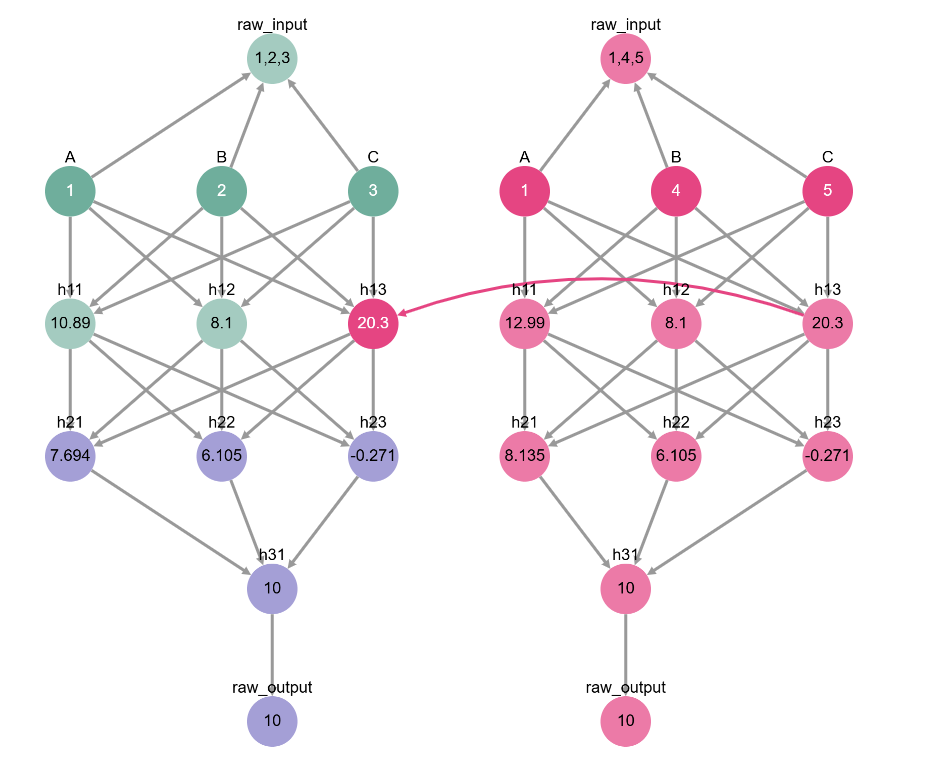

In [ ]:
# does h13 mediate B + C?
A = 1 # fix A across base & source

# try changing the values of B & C - intervening on h13 seems to be enough to restore their computation!
base_input = {'A': A, 'B': 2, 'C': 3}
source_input = {'A': A, 'B': 4, 'C': 5}
toy_model_graph.display_interchange(base_input, {'h13': source_input})

Likewise, we can play around with different base and source values for all of our input variables to convince ourselves that `h22` represents the entire sum `A + B + C`.

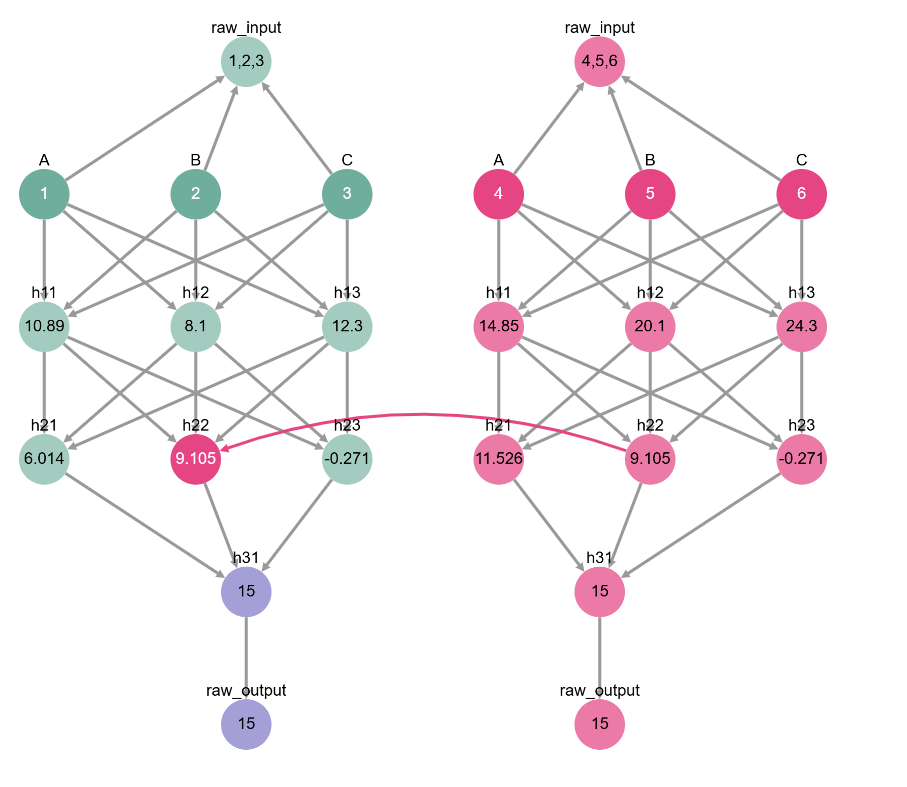

In [ ]:
# does h22 really mediate A + B + C?
base_input = {'A': 1, 'B': 2, 'C': 3}
source_input = {'A': 4, 'B': 5, 'C': 6}
toy_model_graph.display_interchange(base_input, {'h22': source_input})

Well, there we have it! What started out as a random-looking collection of numbers now starts to make some sense. The network saves the value of `A` in neuron `h12`, adds together `B` and `C` and saves the answer in neuron `h13`, and then adds together `h12` and `h13` to get `A + B + C`, storing this information in `h22`. Even though the values themselves don't correspond to `A`, `B`, and `C`, they represent interpretable substeps of the computation.

_(note: this is actually how we constructed the toy example; we created a model that stores information in h12, h13, and h22, and then played around with constants to make it a little harder to see)_

There are two ways in which we can represent our findings. One way is to highlight the **circuit** we found that mediates the model's computation:

![neural network but only with arrows between A, B&C, and A&B&C nodes.](https://github.com/AmirZur/nnsight-tutorials/blob/main/figures/circuit.png?raw=true)

The **circuit** represent a **subset** of the model's computation that is faithful to its performance - by intervening on the circuit instead of the full model, we achieve the same behavior.

Another way is to show the **causal abstraction** between our low-level neural network and the high-level algorithm we discovered:

![mapping between the neurons in the network and the causal variables A, B + C, and A + B + C](https://github.com/AmirZur/nnsight-tutorials/blob/main/figures/causal_abstraction.png?raw=true)

The **causal abstraction** represent an **alignment** between the neural network and variables representing intemediate computations - in this case, `A`, `A + B`, and `A + B + C`. See the [causal abstraction tutorial](https://) to learn more about how to interpret neural networks with causal abstraction.

Now that we've covered the basics of causal mediation analysis, it's time to put your skills to the test! Try out the puzzle below, or continue to the [next causal mediation tutorial](https://), where we analyze a language model.

## *️⃣ Exercise: delving a little deeper

In this tutorial, we found the algorithm that a neural network uses to compute `A + B + C`. But its intermediate values don't look anything like the variables we claim they represent.

For example, we said that `h12` represents `A`, but if we look at its value when `A = 1`, it looks nothing like `A`.

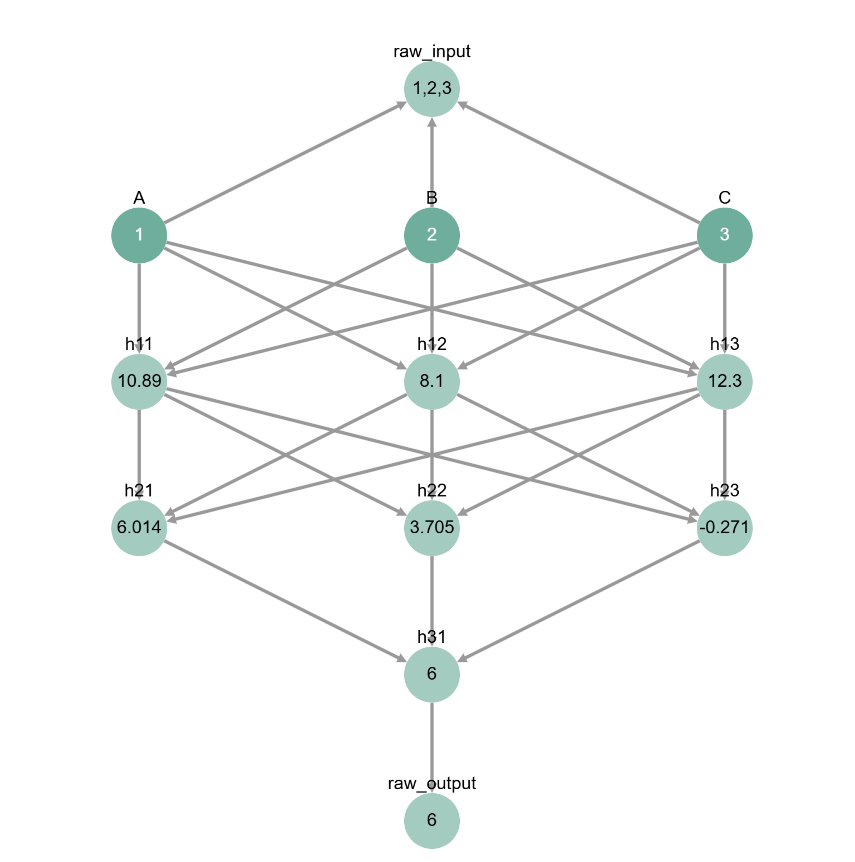

In [ ]:
# how can we be sure h12 represents A?
inputs = [1, 2, 3]
inputs = {'A': inputs[0], 'B': inputs[1], 'C': inputs[2]} # get inputs from cell above
toy_model_graph.display_forward_pass(inputs)

This was kind of done on purpose - if we set up the network so that `h12` equals `A`, then it's hard to motivate going through the whole process of causal mediation analysis to uncover what `h12` does.

But, now that we know `h12` is in charge, we can **reverse engineer** how `A` is "hidden" in `h12`. Try varying the value of `A` slightly (say, 1, then 2, then 3). Do you see any pattern?

This is a linear network, so `h12` has to equal something like `a * A + b` (you can also toggle `B` and `C` to confirm that they don't contribute to the value of `h12`). Can you figure out what `a` and `b` are?

Once you have a guess, you can inspect the model weights to find out!

Run the code below to check your answer.
```
print(toy_model.l1.weight[1]) # weights corresponding to h12
print(toy_model.l1.bias[1]) # bias corresponding to h12
```

Now that you know how we compute `h12`, you can work your way down and reverse engineer the rest of the model. How do we add `B` and `C` together to get `h13`? How about the coefficients behind adding `h12` and `h13` to get `h22`?

This might seem like a long exercise, but it does have some use - if you understand the structure of the model, you can have complete control over it! For example, it should be easy to intervene on the model so that it computes `2 * A + B + C`.

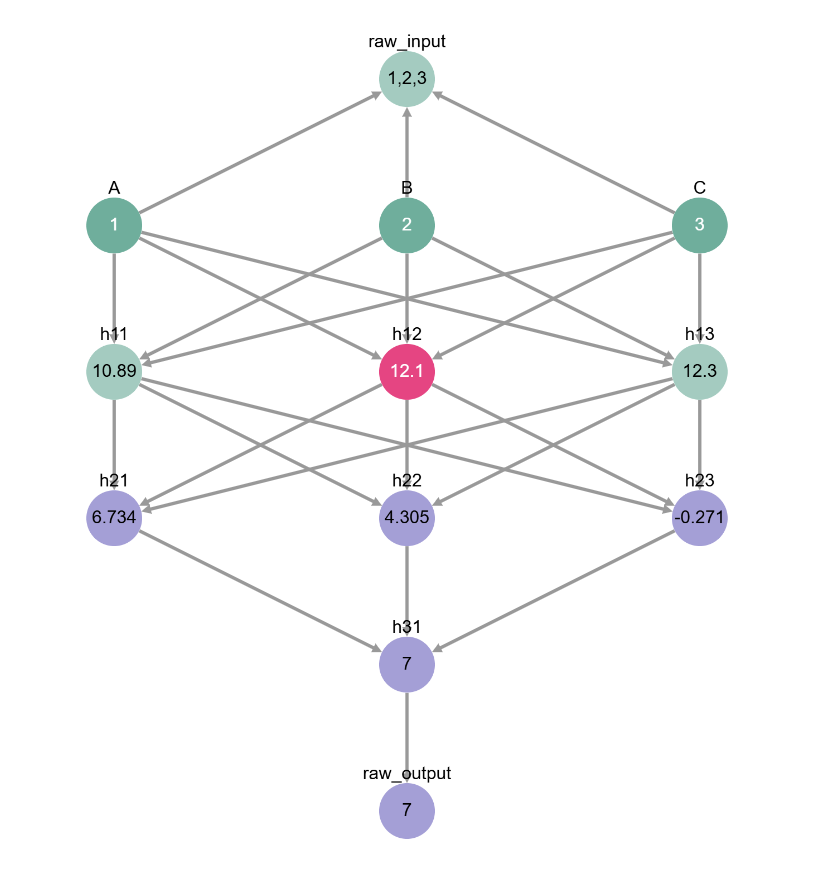

In [ ]:
# now our model computes 2 * 1 + 2 + 3 instead of 1 + 2 + 3!
inputs = [1, 2, 3]
inputs = {'A': inputs[0], 'B': inputs[1], 'C': inputs[2]} # get inputs from cell above
toy_model_graph.display_forward_pass(inputs, intervention={'h12': 12.1})

If you got this far, you really understand the fundamentals of causal mediation analysis! Now let's see how we can apply our understand to analyze a more complex language model. Follow along in [this tutorial](https://)!